https://osdatahub.os.uk/downloads/open/OpenRoads
https://osdatahub.os.uk/downloads/open/OpenZoomstack

In [34]:
from __future__ import annotations

from typing import Any

from shapely import geometry
import fiona
from pathlib import Path
import networkx as nx
from pyproj import Transformer

repo_path = Path.cwd()
if str(repo_path).endswith("connectivity"):
    repo_path = Path.cwd() / "../.."
if not str(repo_path.resolve()).endswith("cityseer-api"):
    raise ValueError("Please check your notebook working directory relative to your project and data paths.")

open_roads_path = Path(repo_path / "temp/os_open_roads/oproad_gb.gpkg")
print("data path", open_roads_path)

# layer keys are Roadlink, RoadNode, MotorwayJunction
layer_keys: list[str] = []
layer_name: str
for layer_key, layer_name in enumerate(  # type: ignore
    fiona.listlayers(open_roads_path)  # type: ignore
):
    layer_keys.append(layer_name)
print(layer_keys)

G = nx.MultiGraph()

# create graph for london
lng, lat = -0.13039709427587876, 51.516434828344366
buffer_dist = 5000
plot_buffer = 3500

transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700")
easting, northing = transformer.transform(lat, lng)
centroid = geometry.Point(easting, northing)
target_bbox = centroid.buffer(buffer_dist).bounds  # type: ignore
plot_bbox = centroid.buffer(plot_buffer).bounds  # type: ignore

data path /Users/gareth/dev/benchmark-urbanism/cityseer-api/demos/connectivity/../../temp/os_open_roads/oproad_gb.gpkg
['RoadLink', 'RoadNode', 'MotorwayJunction']


In [ ]:
# ['RoadLink', 'RoadNode', 'MotorwayJunction']
with fiona.open(open_roads_path, layer="RoadNode") as nodes:  # type: ignore
    for idx, node_data in nodes.items(bbox=target_bbox):  # type: ignore
        node_id: str = node_data["properties"]["id"]
        x: float
        y: float
        x, y = node_data["geometry"]["coordinates"]
        G.add_node(node_id, x=x, y=y)  # type: ignore

n_dropped = 0
with fiona.open(open_roads_path, layer="RoadLink") as edges:  # type: ignore
    for edge_id, edge_data in edges.items(bbox=target_bbox):  # type: ignore
        # x, y = edge_data['geometry']['coordinates']
        props: dict[str, Any] = edge_data["properties"]
        start_nd: str = props["startNode"]
        end_nd: str = props["endNode"]
        names: set[str] = set()
        for name_key in ["name1", "name2"]:
            name: str | None = props[name_key]
            if name is not None:
                names.add(name)
        refs: set[str] = set()
        for ref_key in ["roadClassificationNumber"]:
            ref: str | None = props[ref_key]
            if ref is not None:
                refs.add(ref)
        highways: set[str] = set()
        for highway_key in ["roadFunction", "roadClassification"]:  # 'formOfWay'
            highway = props[highway_key]
            if highway is not None:
                highways.add(highway)
        if props["trunkRoad"]:
            highways.add("IsTrunk")
        if props["primaryRoute"]:
            highways.add("IsPrimary")
        # filter highways
        highways.difference_update({"Not Classified", "Unclassified", "Unknown", "Restricted Local Access Road"})
        geom = geometry.LineString(edge_data["geometry"]["coordinates"])  # type: ignore
        geom = geom.simplify(5)
        # do not add edges to clipped extents
        if start_nd not in G or end_nd not in G:
            n_dropped += 1
            continue
        G.add_edge(start_nd, end_nd, names=list(names), refs=list(refs), highways=list(highways), geom=geom)

print("Nodes", G.number_of_nodes())
print("Edges", G.number_of_edges())
print(f"Dropped {n_dropped} edges where not both start and end nodes were present.")
G_agg: nx.MultiGraph = G.copy()

In [25]:
import networkx as nx
from tqdm import tqdm
from cityseer.tools.graphs import NodeKey, EdgeData


def route_continuity(nx_multigraph: nx.MultiGraph, method: str):
    """ """

    def _clean_vals(vals: list[str]) -> set[str]:
        clean_vals: list[str] = []
        for val in vals:
            # highways category has residential, service, etc.
            if val not in [None, "residential", "service", "footway"]:
                clean_vals.append(val)
        return set(clean_vals)

    def _intersect_vals(vals_a: list[str], vals_b: list[str]) -> bool:
        clean_vals_a = _clean_vals(vals_a)
        clean_vals_b = _clean_vals(vals_b)
        itx = clean_vals_a.intersection(clean_vals_b)
        return len(itx) > 0

    def _recurse_edges(
        _nx_multigraph: nx.MultiGraph,
        _target_key: str,
        _target_vals: list[str],
        _a_nd_key: NodeKey,
        _b_nd_key: NodeKey,
        _edge_idx: int,
        agg_edge_lengths: list[float],
        visited_edges: list[str] = [],
    ):
        edge_nodes = tuple(sorted([str(_a_nd_key), str(_b_nd_key)]))
        edge_key = f"{edge_nodes[0]}_{edge_nodes[1]}_{_edge_idx}"
        if edge_key in visited_edges:
            return
        else:
            visited_edges.append(edge_key)
        nested_edge_data: EdgeData = _nx_multigraph[_a_nd_key][_b_nd_key][_edge_idx]
        if _target_key not in nested_edge_data:
            return
        nested_target_vals: list[str] = nested_edge_data[_target_key]
        if not _intersect_vals(_target_vals, nested_target_vals):
            return
        agg_edge_lengths.append(nested_edge_data["geom"].length)
        # find all neighbouring edge pairs
        a_nb_pairs: list[tuple[NodeKey, NodeKey]] = [
            (_a_nd_key, ann) for ann in nx.neighbors(_nx_multigraph, _a_nd_key) if ann != _b_nd_key  # type: ignore
        ]
        b_nb_pairs: list[tuple[NodeKey, NodeKey]] = [
            (_b_nd_key, bnn) for bnn in nx.neighbors(_nx_multigraph, _b_nd_key) if bnn != _a_nd_key  # type: ignore
        ]
        for nested_a_nd_key, nested_b_nd_key in a_nb_pairs + b_nb_pairs:
            nested_edge_idx: int
            for nested_edge_idx in _nx_multigraph[nested_a_nd_key][nested_b_nd_key].keys():
                _recurse_edges(
                    _nx_multigraph,
                    _target_key,
                    _target_vals,
                    nested_a_nd_key,
                    nested_b_nd_key,
                    nested_edge_idx,
                    agg_edge_lengths,
                    visited_edges,
                )

    if method in ["names", "refs", "highways"]:
        target_key: str = method
    else:
        raise ValueError(f"Method of {method} is not recognised.")
    # iter edges
    for a_nd_key, b_nd_key, edge_idx, edge_data in tqdm(nx_multigraph.edges(keys=True, data=True)):  # type: ignore
        if target_key not in edge_data:
            nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg"] = None
        target_vals = edge_data[target_key]
        agg_edge_lengths: list[float] = []
        visited_edges: list[str] = []
        _recurse_edges(
            nx_multigraph, target_key, target_vals, a_nd_key, b_nd_key, edge_idx, agg_edge_lengths, visited_edges
        )
        # length sum
        agg_len = sum(agg_edge_lengths)
        if f"{target_key}_agg" in nx_multigraph[a_nd_key][b_nd_key][edge_idx]:
            current_agg_len = nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg_length"]
            if agg_len > current_agg_len:
                nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg_length"] = agg_len
        else:
            nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg_length"] = agg_len
        # counts
        agg_count = len(agg_edge_lengths)
        if f"{target_key}_agg_count" in nx_multigraph[a_nd_key][b_nd_key][edge_idx]:
            current_agg_count = nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg_count"]
            if agg_count > current_agg_count:
                nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg_count"] = agg_count
        else:
            nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg_count"] = agg_count

In [36]:
import numpy as np
import numpy.typing as npt
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


def plot_aggs(nx_multigraph: nx.MultiGraph, edge_metrics_key: str):
    _fig, ax = plt.subplots(1, 1, dpi=200, figsize=(10, 10))
    min_x, min_y, max_x, max_y = plot_bbox  # type: ignore
    # extract data for shaping
    edge_vals: list[str] = []
    edge_geoms: list[geometry.LineString] = []
    for _, _, edge_data in tqdm(nx_multigraph.edges(data=True)):  # type: ignore
        edge_vals.append(edge_data[edge_metrics_key])  # type: ignore
        edge_geoms.append(edge_data["geom"])  # type: ignore
    edge_vals_arr: npt.NDArray[np.float_] = np.array(edge_vals)
    edge_vals_arr = np.clip(edge_vals_arr, np.percentile(edge_vals_arr, 1), np.percentile(edge_vals_arr, 99))
    # plot using geoms
    n_edges = edge_vals_arr.shape[0]
    for idx in tqdm(range(n_edges)):
        xs = np.array(edge_geoms[idx].coords.xy[0])
        ys = np.array(edge_geoms[idx].coords.xy[1])
        if np.any(xs < min_x) or np.any(xs > max_x):
            continue
        if np.any(ys < min_y) or np.any(ys > max_y):
            continue
        # normalise val
        edge_val = edge_vals_arr[idx]
        norm_val = (edge_val - edge_vals_arr.min()) / (edge_vals_arr.max() - edge_vals_arr.min())
        val_shape = norm_val * 0.95 + 0.05
        ax.plot(xs, ys, linewidth=val_shape, color="#ef1a33")
    ax.axis("off")
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.show()

100%|██████████| 301443/301443 [00:21<00:00, 13824.11it/s]


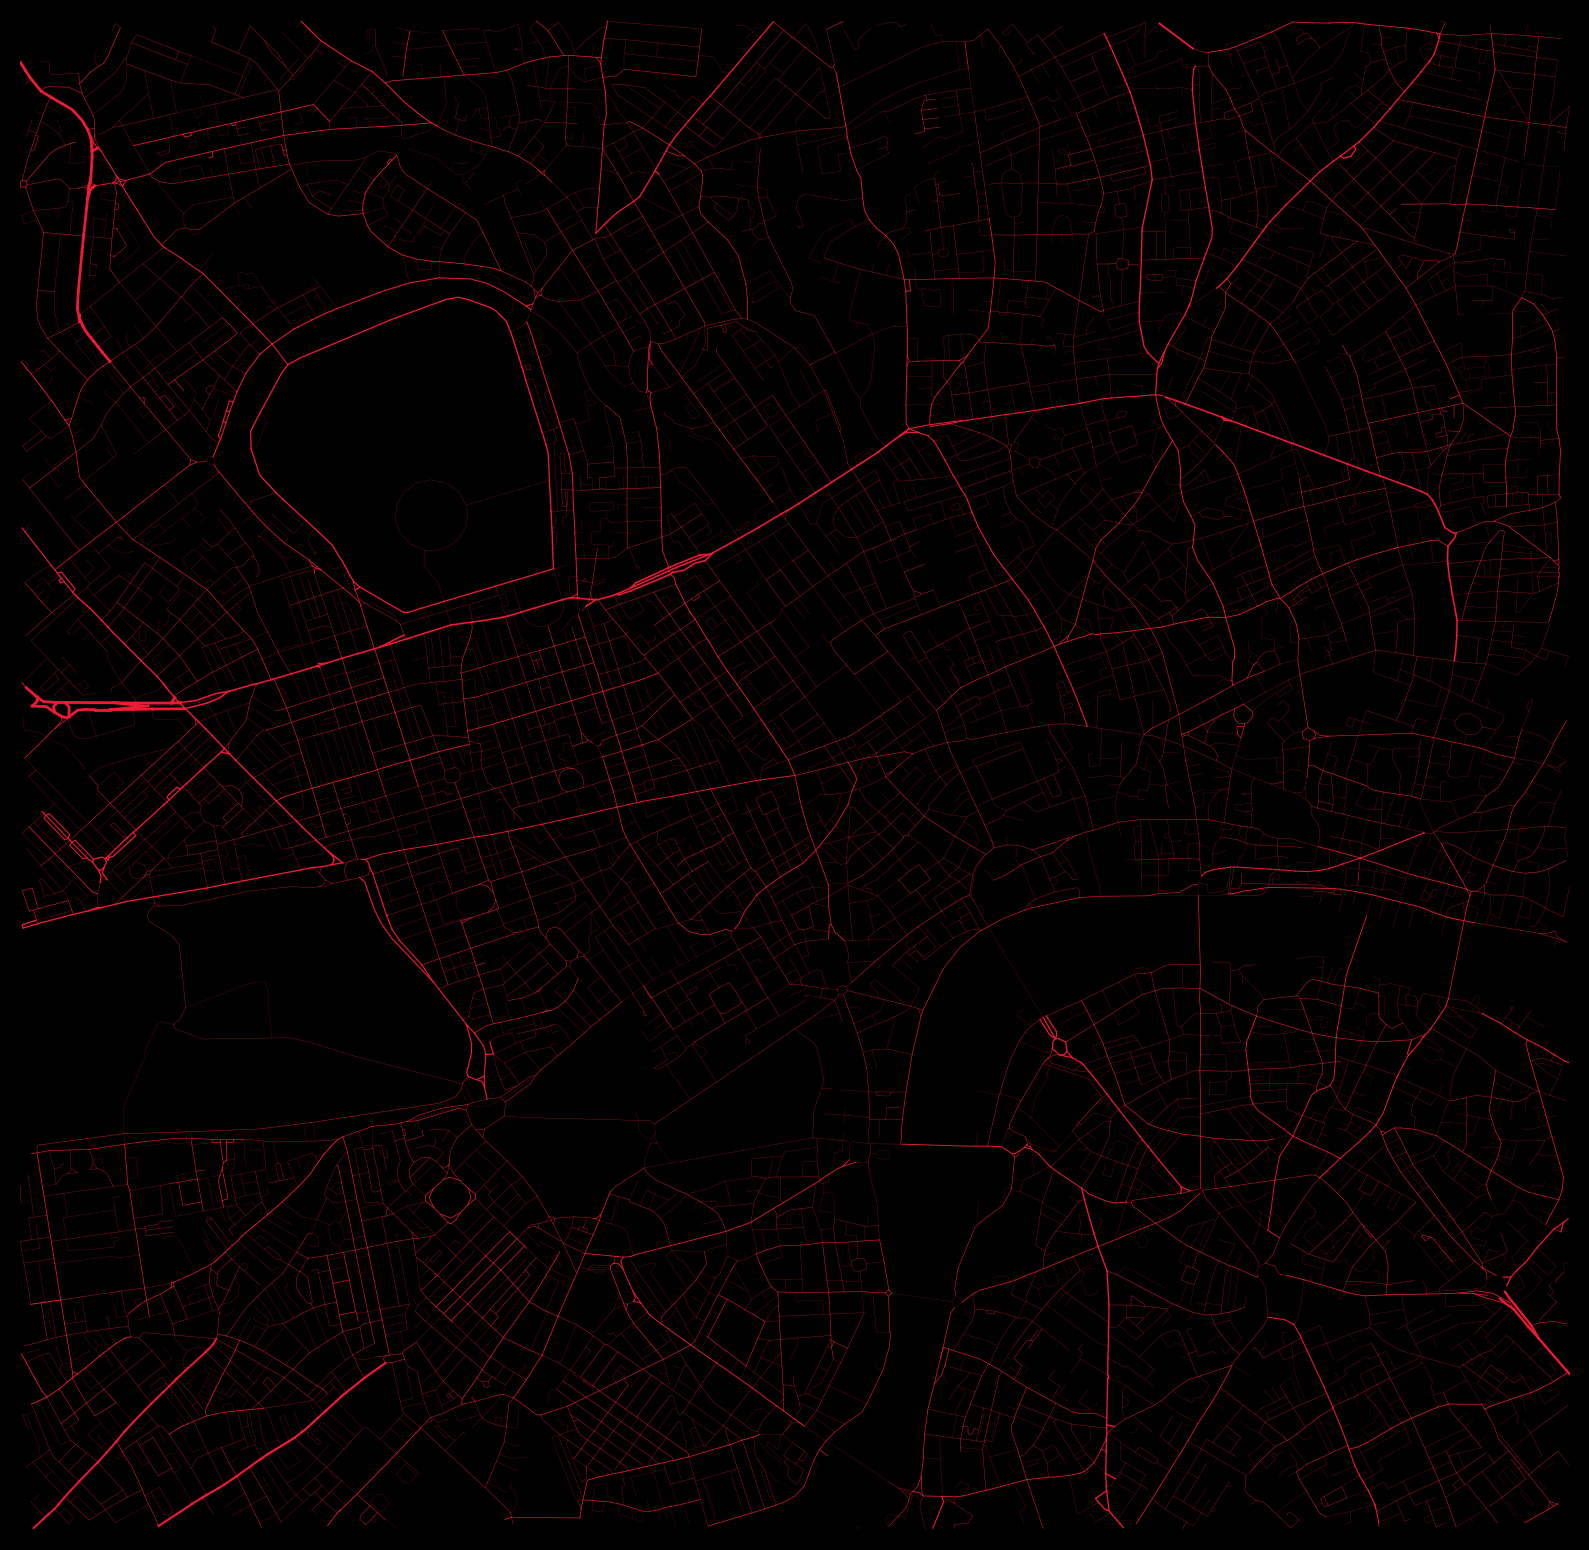

100%|██████████| 301443/301443 [00:22<00:00, 13325.04it/s]


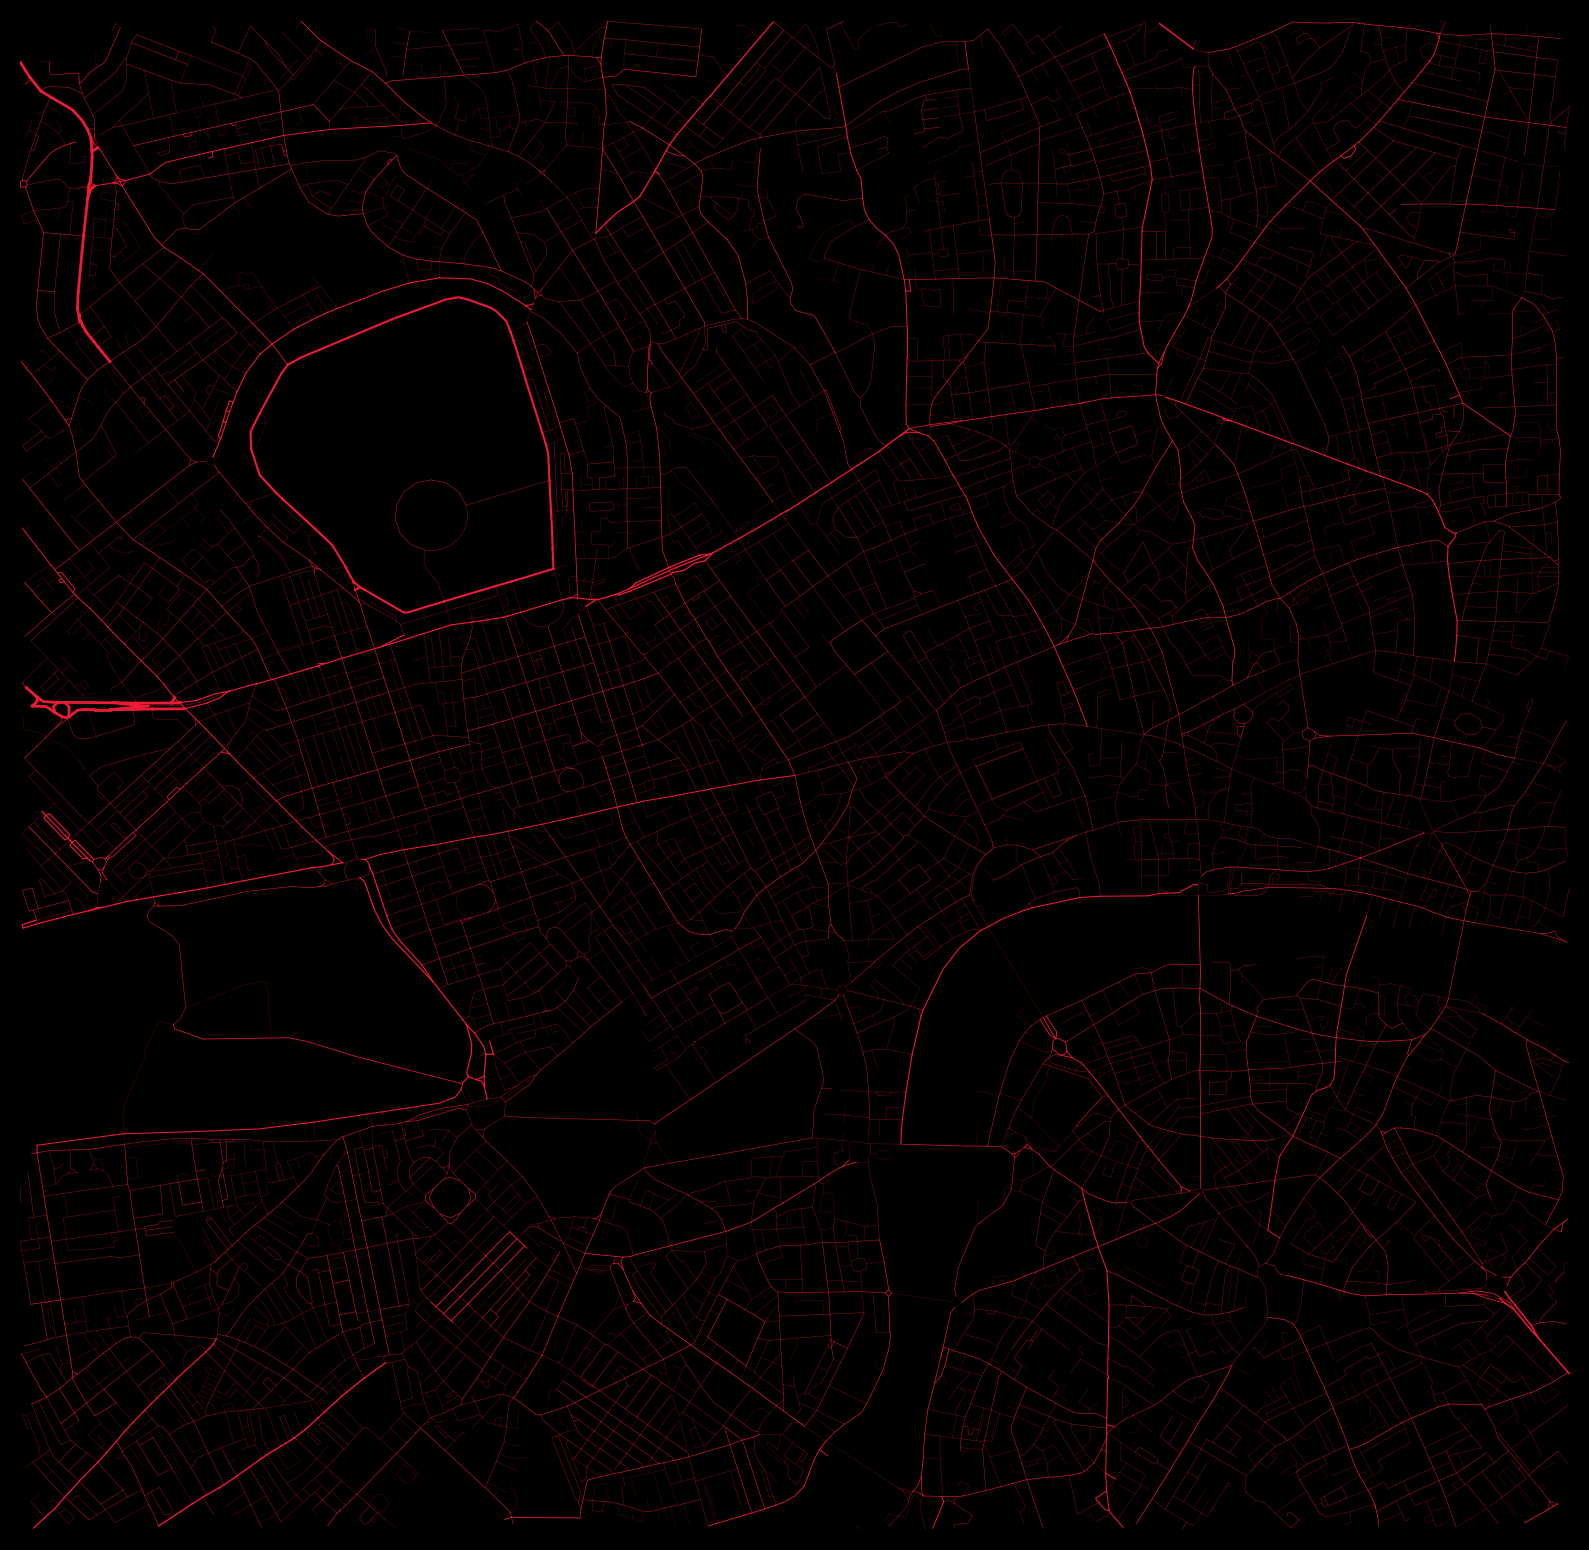

In [37]:
# route_continuity(G_agg, method="names")
plot_aggs(G_agg, "names_agg_count")
plot_aggs(G_agg, "names_agg_length")

100%|██████████| 301443/301443 [00:19<00:00, 15100.46it/s]


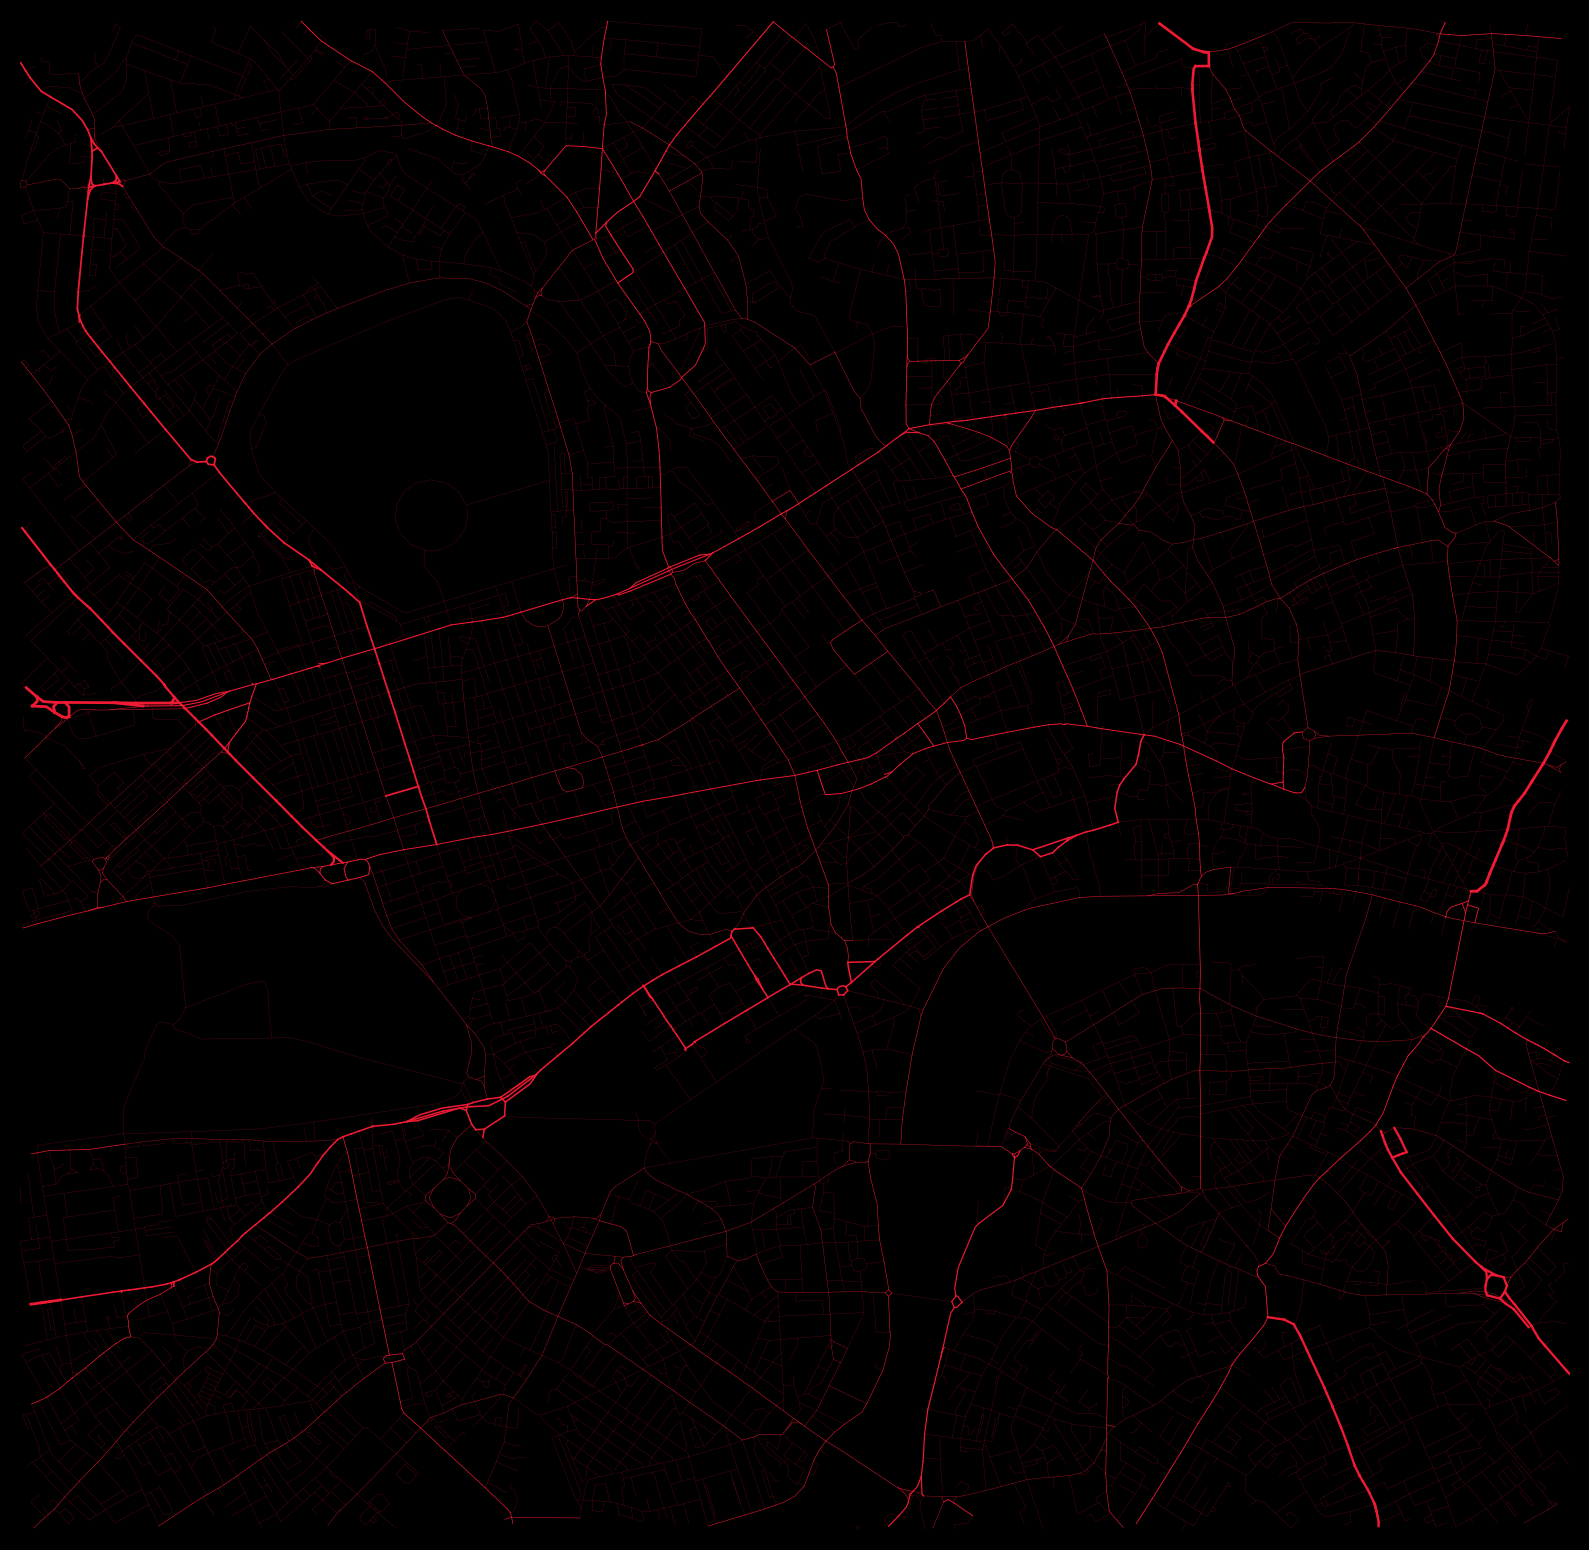

100%|██████████| 301443/301443 [00:20<00:00, 14769.60it/s]


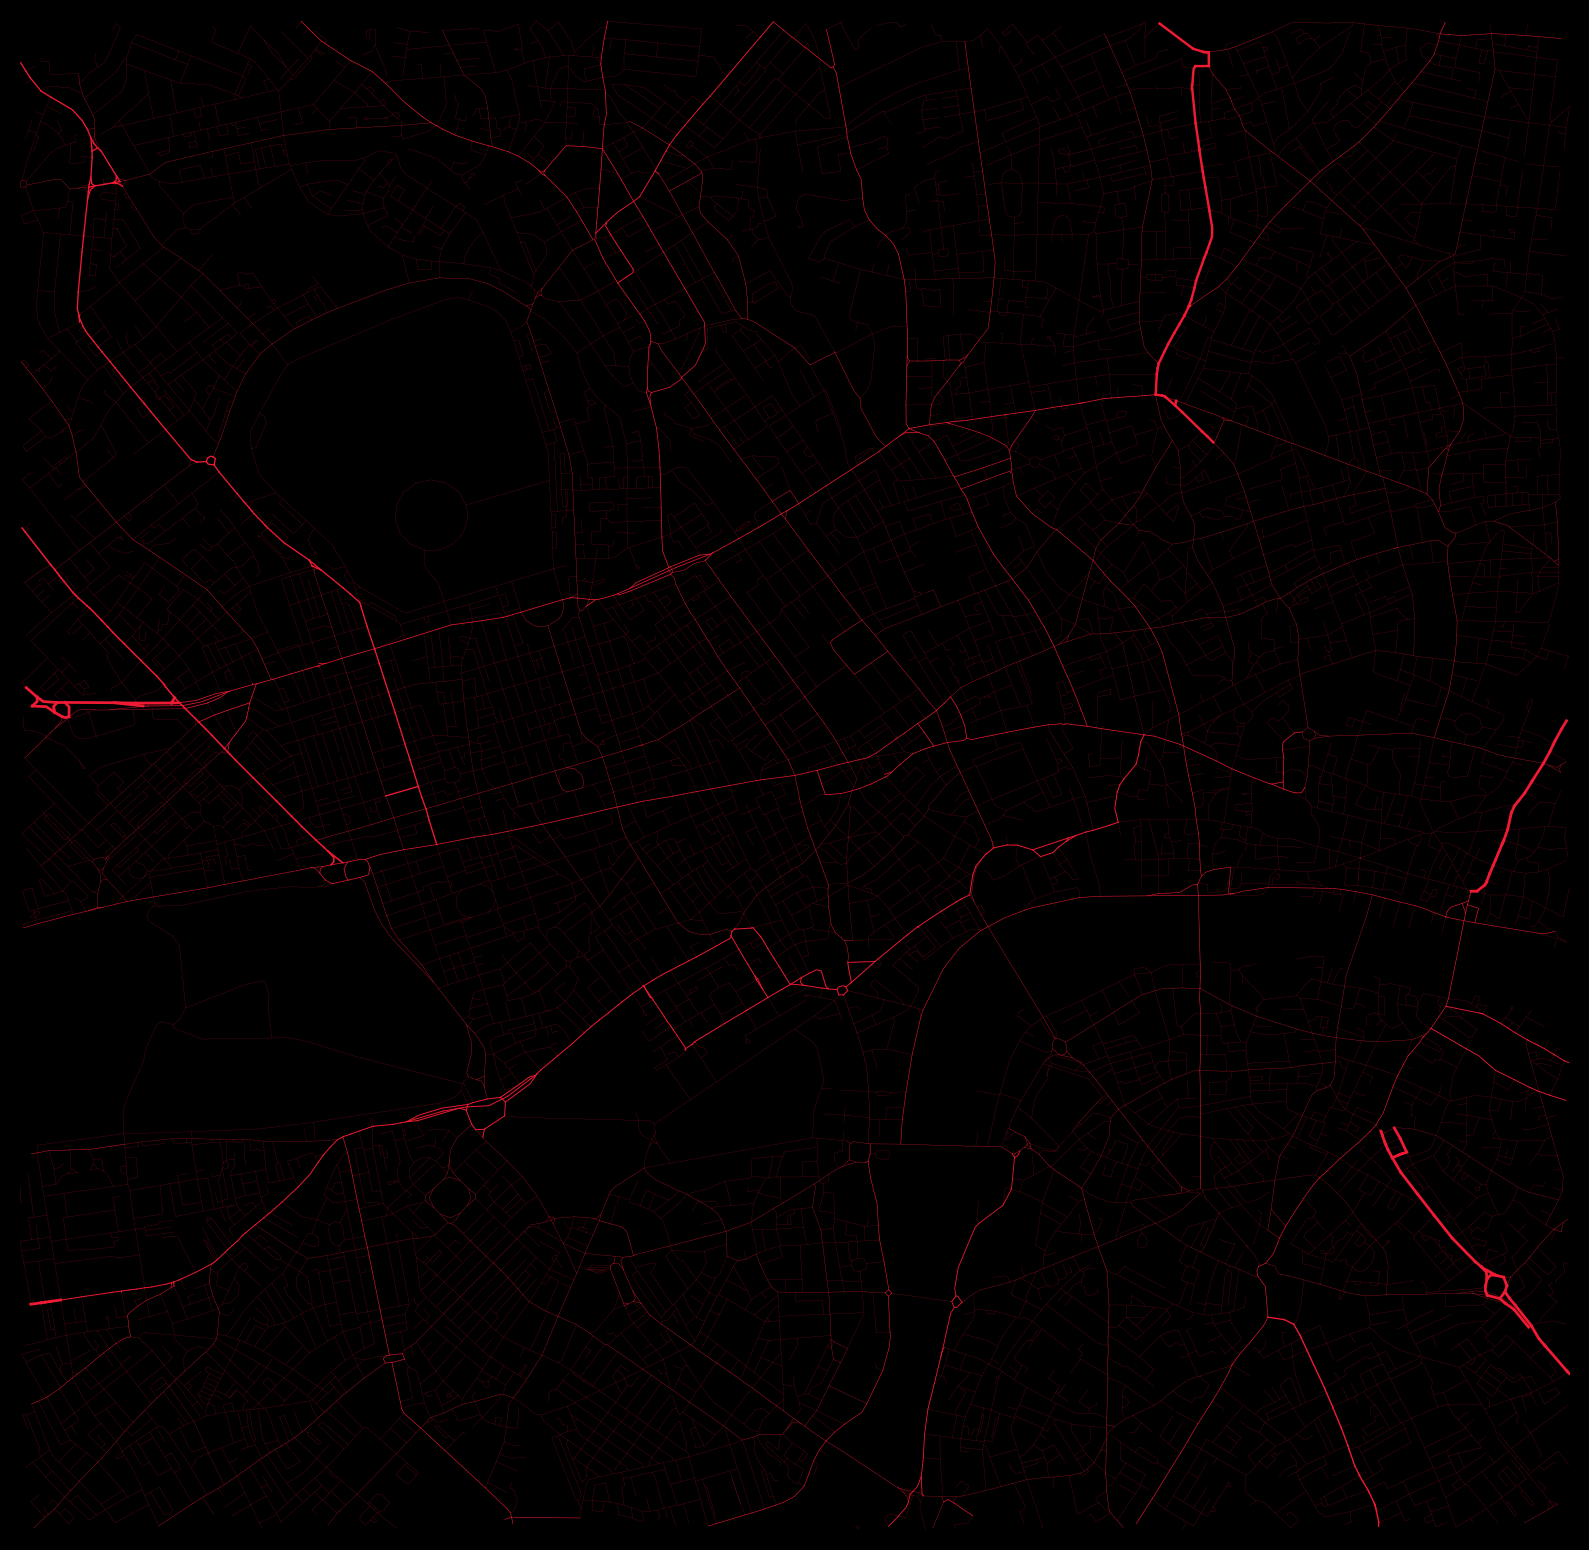

In [38]:
route_continuity(G_agg, method="refs")
plot_aggs(G_agg, "refs_agg_count")
plot_aggs(G_agg, "refs_agg_length")

In [ ]:
route_continuity(G_agg, method="highways")
plot_aggs("highways_agg_count")
plot_aggs("highways_agg_length")